<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>



<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/Operations-onGeoDF/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Binary Spatial operations on  Geo Dataframes

This time the spatial operations will be applied when we have as input two GDFs. 

## Getting ready

The links to the our maps on GitHub are here:

In [1]:
linkWorldMap="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/WORLD/worldMaps.gpkg"
linkBrazil="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/BRAZIL/brazil_5880.gpkg"
linkIndicators="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/WORLD/worldindicators.json"

Let me introduce another [data source on seaports](https://msi.nga.mil/Publications/WPI). Their locations in long/lat is stored in the file **seaports.csv** which we already have on GitHub:

In [2]:
linkSeaPorts='https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/WORLD/seaports.csv'

Let's get some maps:

In [3]:
import geopandas as gpd

#world 
world_rivers=gpd.read_file(linkWorldMap,layer='rivers')
#brazil 
brazil5880=gpd.read_file(linkBrazil,layer='country')
airports_brazil5880=gpd.read_file(linkBrazil,layer='airports')
states_brazil5880=gpd.read_file(linkBrazil,layer='states')
municipalities_brazil5880=gpd.read_file(linkBrazil,layer='municipalities')
#some indicators
indicators=gpd.read_file(linkIndicators)

# the seaports
import pandas as pd 
infoseaports=pd.read_csv(linkSeaPorts)

In [4]:
# the sesports data has too manny columns:
len(infoseaports.columns)

108

Let me keep some columns, and turn the DF into a GDF:

In [5]:
#rename
infoseaports.rename(columns={'Main Port Name':'seaport_name','Country Code':'country_name'},inplace=True)

#keep few columns
infoseaports=infoseaports.loc[:,['seaport_name', 'country_name','Latitude', 'Longitude']]

#spatial points (unprojected)
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                           geometry=gpd.points_from_xy(infoseaports.Longitude,
                                                       infoseaports.Latitude), 
                          crs=4326)# notice it is unprojected

# keep Brazil
seaports_bra=seaports[seaports['country_name']=='Brazil'].copy()

# reset indexes
seaports_bra.reset_index(drop=True, inplace=True)

# reprojecting
seaports_brazil5880=seaports_bra.to_crs(5880) # projected crs

**Before proceeding**, let me compute some GDFs we created the previous session:


* The centroid of Brazil

In [6]:
brazil5880_cen=brazil5880.centroid

- Large Brazilian airports

In [7]:
large_airports=airports_brazil5880.query("airport_type=='large_airport'")

- Amazon Rivers

In [8]:
AmazonSystem=world_rivers.query("SYSTEM=='Amazon'")
AmazonSystem_5880=AmazonSystem.to_crs(5880)

- The states in the East, West, South, and North

In [9]:
mid_x,mid_y=brazil5880_cen.x[0],brazil5880_cen.y[0]

# the north
N_brazil=states_brazil5880.cx[:,mid_y:]
# the south
S_brazil=states_brazil5880.cx[:,:mid_y]
# the west
W_brazil=states_brazil5880.cx[:mid_x,:]
# the east
E_brazil=states_brazil5880.cx[mid_x:,:]

- The mean fragility by region of the world

In [10]:
indicatorsByRegion=indicators.dissolve(
    by="region", #groupby()
    aggfunc={"fragility": "mean"}, #agg()
    )

In [11]:
# You may need to install if using Colab
# !pip install mapclassify


_____________



## I. Distance

Distance is a key binary operation as so many practical policy matters depend on knowing distances between objects in space.

Any pair of rightly projected GDFs have a distance between them. Below we can make  query using distances:

> Which are the airports whose distance to Brazil centroid is > 2500000?

In [12]:
# this is the centroid we have:
brazil5880_cen

0    POINT (5085264.134 8827720.201)
dtype: geometry

Then,

In [13]:
airports_brazil5880[airports_brazil5880.distance(brazil5880_cen[0]) > 2500000]

,airport_name,airport_type,elevation_ft,region,municipality,geometry
4104,Viatec Aviação Agrícola Airport,small_airport,92.0,Rio Grande do Sul,Santa Vitória do Palmar,POINT (5068397.782 6323060.053)
4106,Santa Vitória do Palmar Airport,small_airport,82.0,Rio Grande do Sul,Santa Vitória Do Palmar,POINT (5060939.818 6291358.318)
6662,Trindade Heliport,heliport,NaN,Espírito Santo,Vitória,POINT (7565615.936 7537143.55)


The results can be confirmed visually:

<Axes: >

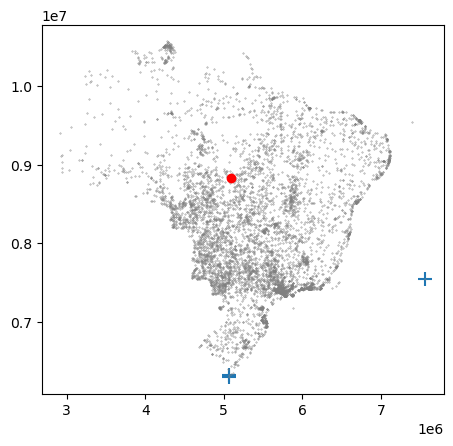

In [14]:
base=airports_brazil5880[airports_brazil5880.distance(brazil5880_cen.iloc[0]) > 2500000].plot(marker='+',markersize=100)
airports_brazil5880.plot(ax=base,color='grey', markersize=0.1)
brazil5880_cen.plot(ax=base,color='red')

Let me review how distances work between different kinds of geometries:

### a.  Distance between points

We have these points:


In [15]:
seaports_brazil5880.head()

,seaport_name,country_name,Latitude,Longitude,geometry
0,Dtse / Gegua Oil Terminal,Brazil,-22.816667,-43.150000,POINT (6112865.27 7434885.819)
1,Porto De Mucuripe,Brazil,-3.716667,-38.483333,POINT (6723610.313 9573897.029)
2,Portocel,Brazil,-19.850000,-40.050000,POINT (6459540.7 7743872.147)
3,Santa Clara,Brazil,-20.883333,-51.366667,POINT (5273988.618 7687595.596)
4,Aratu,Brazil,-12.783333,-38.500000,POINT (6681955.632 8535904.773)


In [21]:
large_airports.head()

,airport_name,airport_type,elevation_ft,region,municipality,geometry
0,Guarulhos - Governador André Franco Montoro In...,large_airport,2461.0,São Paulo,São Paulo,POINT (5769392.959 7387510.487)
1,Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro,POINT (6102623.812 7436387.271)
4,Presidente Juscelino Kubitschek International ...,large_airport,3497.0,Distrito Federal,Brasília,POINT (5651010.181 8235390.09)
5,Deputado Luiz Eduardo Magalhães International ...,large_airport,64.0,Bahia,Salvador,POINT (6700330.807 8520415.591)
9,Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte,POINT (6051718.72 7797008.905)


For results of distance operation to be more insightful, we may do this:

In [23]:
# index will be names of airports/seaports instead of numbers
large_airports.set_index('airport_name',inplace=True)
seaports_brazil5880.set_index('seaport_name',inplace=True)

> The distance from each airport to the "Dtse / Gegua Oil Terminal"

In [30]:
large_airports.distance(seaports_brazil5880.geometry.iloc[0])

airport_name
Guarulhos - Governador André Franco Montoro International Airport    3.467242e+05
Rio Galeão – Tom Jobim International Airport                         1.035093e+04
Presidente Juscelino Kubitschek International Airport                9.241846e+05
Deputado Luiz Eduardo Magalhães International Airport                1.234298e+06
Tancredo Neves International Airport                                 3.672493e+05
Eduardo Gomes International Airport                                  2.854494e+06
Hercílio Luz International Airport                                   7.681356e+05
Val de Cans/Júlio Cezar Ribeiro International Airport                2.462792e+06
dtype: float64

What about computing...

> All the distances between large aiports and seaports (in km)

In [32]:
# apply creates a LOOP, computes distances from each seaport to all large airports
seaports_brazil5880.geometry.apply\
(lambda seaport: large_airports.geometry.distance(seaport)/1000)

airport_name,Guarulhos - Governador André Franco Montoro International Airport,Rio Galeão – Tom Jobim International Airport,Presidente Juscelino Kubitschek International Airport,Deputado Luiz Eduardo Magalhães International Airport,Tancredo Neves International Airport,Eduardo Gomes International Airport,Hercílio Luz International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
seaport_name,,,,,,,,
Dtse / Gegua Oil Terminal,346.724171,10.350933,924.184620,1234.297632,367.249276,2854.493600,768.135646,2462.791784
Porto De Mucuripe,2385.543307,2225.886834,1715.246883,1053.738618,1899.676213,2397.739727,2901.295202,1141.963646
Portocel,776.722303,471.101490,946.209008,813.018817,411.269111,2867.979624,1232.521248,2266.253017
Santa Clara,579.203362,865.876382,664.999298,1651.678293,785.388683,2189.659524,805.599343,2185.898767
Aratu,1466.826530,1242.804930,1073.851757,24.032516,971.167168,2609.953079,1975.180167,1690.370196
Cabedelo,2248.124981,2023.173930,1747.914940,786.022123,1751.230863,2830.123680,2757.957782,1641.263825
Imbituba,578.310920,814.278300,1377.148556,2031.882238,1072.105305,3042.768039,63.612808,2983.998277
Angra Dos Reis,225.003606,111.795735,883.019058,1308.028199,380.901616,2791.717379,671.807826,2455.089996
Natal,2341.056650,2128.327377,1799.131283,891.421964,1843.689307,2774.776071,2853.930050,1556.780342


If we save the matrix...

In [33]:
D_Matrix_sea_air=seaports_brazil5880.geometry.apply \
                (lambda seaport: large_airports.geometry.distance(seaport)/1000)

We can compute some distance stats from there:

In [34]:
Stat_sea_air=pd.DataFrame()
Stat_sea_air['mean']=D_Matrix_sea_air.mean(axis=1) # mean D to all airports
Stat_sea_air['min']=D_Matrix_sea_air.min(axis=1)# min D to all airports
Stat_sea_air['max']=D_Matrix_sea_air.max(axis=1)# max D to all airports

# see some
Stat_sea_air.head(10)

,mean,min,max
seaport_name,,,
Dtse / Gegua Oil Terminal,1121.028458,10.350933,2854.493600
Porto De Mucuripe,1965.136304,1053.738618,2901.295202
Portocel,1223.134327,411.269111,2867.979624
Santa Clara,1216.037957,579.203362,2189.659524
Aratu,1381.773293,24.032516,2609.953079
Cabedelo,1973.226516,786.022123,2830.123680
Imbituba,1495.513055,63.612808,3042.768039
Angra Dos Reis,1103.420427,111.795735,2791.717379
Natal,2023.639130,891.421964,2853.930050


Of course, the idmax and idmin could come in handy:

In [35]:
# farthest airport to each seaport
D_Matrix_sea_air.idxmax(axis=1).head()

seaport_name
Dtse / Gegua Oil Terminal    Eduardo Gomes International Airport
Porto De Mucuripe             Hercílio Luz International Airport
Portocel                     Eduardo Gomes International Airport
Santa Clara                  Eduardo Gomes International Airport
Aratu                        Eduardo Gomes International Airport
dtype: object

In [36]:
# farthest seaport to each airport
D_Matrix_sea_air.idxmax(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport    Manaus
Rio Galeão – Tom Jobim International Airport                         Manaus
Presidente Juscelino Kubitschek International Airport                Manaus
Deputado Luiz Eduardo Magalhães International Airport                Manaus
Tancredo Neves International Airport                                 Manaus
dtype: object

In [37]:
# closest airport to each seaport
D_Matrix_sea_air.idxmin(axis=1).head()

seaport_name
Dtse / Gegua Oil Terminal         Rio Galeão – Tom Jobim International Airport
Porto De Mucuripe            Deputado Luiz Eduardo Magalhães International ...
Portocel                                  Tancredo Neves International Airport
Santa Clara                  Guarulhos - Governador André Franco Montoro In...
Aratu                        Deputado Luiz Eduardo Magalhães International ...
dtype: object

In [38]:
# closest seaport to each airport
D_Matrix_sea_air.idxmin(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport                       Santos
Rio Galeão – Tom Jobim International Airport                         Dtse / Gegua Oil Terminal
Presidente Juscelino Kubitschek International Airport                              Santa Clara
Deputado Luiz Eduardo Magalhães International Airport                         Port De Salvador
Tancredo Neves International Airport                                 Dtse / Gegua Oil Terminal
dtype: object

### b. Distance between line and point

Once we know understand how **distance** and idxmin/idxmax work, we can feel comfortable in this stage. 

Let's use these rivers from before:

In [40]:
AmazonSystem_5880.set_index("RIVER",inplace=True)
AmazonSystem_5880

,SYSTEM,geometry
RIVER,,
Amazon,Amazon,"MULTILINESTRING ((4191497.619 9597916.381, 425..."
Guapore,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378..."
Japura,Amazon,"MULTILINESTRING ((3782432.967 9748590.005, 382..."
Madeira,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378..."
Madre de Dios,Amazon,"MULTILINESTRING ((3407019.812 8246998.613, 343..."
Purus,Amazon,"MULTILINESTRING ((3008899.534 8748725.178, 305..."
Putamayo,Amazon,"MULTILINESTRING ((2478636.973 10162886.59, 246..."
Rio Branco,Amazon,"MULTILINESTRING ((4372657.932 10403233.815, 43..."
Rio Juruena,Amazon,"MULTILINESTRING ((4488340.769 8382801.957, 456..."


Then,
> Distance from river Tapajos to Guarulhos airport

In [43]:
airName='Guarulhos - Governador André Franco Montoro International Airport'
rivName='Tapajos'
AmazonSystem_5880.geometry.loc[rivName].distance(large_airports.geometry.loc[airName])/1000

2170.030197547702

We can compute the distance matrix now:

In [44]:
D_Matrix_amazRivs_air=AmazonSystem_5880.geometry.apply \
                (lambda river: large_airports.geometry.distance(river)/1000)

In [45]:
Stat_amz_air=pd.DataFrame()
Stat_amz_air['mean']=D_Matrix_amazRivs_air.mean(axis=1) # mean D to all airports
Stat_amz_air['min']=D_Matrix_amazRivs_air.min(axis=1)# min D to all airports
Stat_amz_air['max']=D_Matrix_amazRivs_air.max(axis=1)# max D to all airports

# see some
Stat_amz_air.head(10)

,mean,min,max
RIVER,,,
Amazon,1764.132480,25.549158,2865.306190
Guapore,1822.694503,983.345006,2397.410373
Japura,2495.652965,502.953032,3214.712005
Madeira,1949.986161,153.127907,2652.416364
Madre de Dios,2237.270472,983.345006,2934.051647
Purus,2143.371707,150.306441,2848.394230
Putamayo,2784.484656,853.437589,3437.832352
Rio Branco,2353.394115,264.452689,3241.167974
Rio Juruena,1498.931579,525.908802,2139.336751


In [46]:
# closest river to each airport
D_Matrix_amazRivs_air.idxmin(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport    Xingu
Rio Galeão – Tom Jobim International Airport                         Xingu
Presidente Juscelino Kubitschek International Airport                Xingu
Deputado Luiz Eduardo Magalhães International Airport                Xingu
Tancredo Neves International Airport                                 Xingu
dtype: object

In [47]:
# farthest river to each airport
D_Matrix_amazRivs_air.idxmax(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport    Rio Maranon
Rio Galeão – Tom Jobim International Airport                         Rio Maranon
Presidente Juscelino Kubitschek International Airport                Rio Maranon
Deputado Luiz Eduardo Magalhães International Airport                Rio Maranon
Tancredo Neves International Airport                                 Rio Maranon
dtype: object

### c. Between Polygon and Point

Let me re use the world rivers to get the rivers in a couple of systems:

In [49]:
river_systems=world_rivers.query("SYSTEM in ['Amazon','Parana']")
river_systems

,RIVER,SYSTEM,geometry
1,Amazon,Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
24,Guapore,Amazon,"MULTILINESTRING ((-65.1024 -10.27593, -65.1201..."
29,Japura,Amazon,"MULTILINESTRING ((-64.94595 -2.23269, -64.5731..."
37,Madeira,Amazon,"MULTILINESTRING ((-65.1024 -10.27593, -65.0844..."
38,Madre de Dios,Amazon,"MULTILINESTRING ((-68.84791 -15.35547, -68.594..."
55,Paraguay,Parana,"MULTILINESTRING ((-53.47152 -16.67963, -54.309..."
56,Parana,Parana,"MULTILINESTRING ((-58.48091 -27.30186, -58.402..."
59,Purus,Amazon,"MULTILINESTRING ((-72.21624 -10.77936, -71.803..."
60,Putamayo,Amazon,"MULTILINESTRING ((-76.65652 1.36565, -76.77346..."
62,Rio Branco,Amazon,"MULTILINESTRING ((-59.64679 3.62898, -60.19013..."


Let me combine per system:

In [52]:
ama_para=river_systems.dissolve(by='SYSTEM')
ama_para.drop(columns='RIVER',inplace=True)
ama_para

,geometry
SYSTEM,
Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
Parana,"MULTILINESTRING ((-53.47152 -16.67963, -54.309..."


We still have lines:

<Axes: >

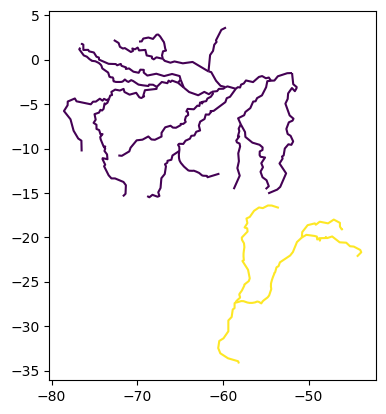

In [53]:
ama_para.plot(cmap='viridis')

But we will have polygons after this:

<Axes: >

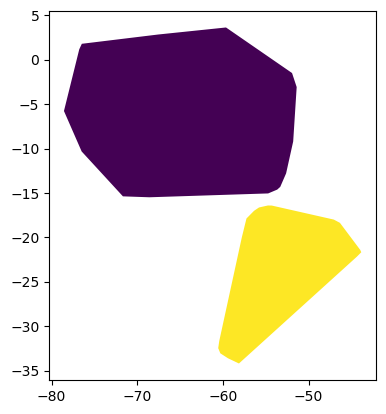

In [59]:
ama_para.convex_hull.plot(cmap='viridis')

As we have a geoseries of two geometries...

In [60]:
ama_para.convex_hull,type(ama_para.convex_hull)

(SYSTEM
 Amazon    POLYGON ((-68.59431 -15.48713, -71.67654 -15.3...
 Parana    POLYGON ((-58.13602 -34.19917, -59.41318 -33.6...
 dtype: geometry,
 geopandas.geoseries.GeoSeries)

Let's turn that into a GDF:

In [61]:
ama_para_hulls=ama_para.convex_hull.to_frame()
ama_para_hulls.rename(columns={0:'geometry'},inplace=True)
ama_para_hulls=ama_para_hulls.set_geometry('geometry')
ama_para_hulls.crs="EPSG:5880"

#voila
ama_para_hulls

,geometry
SYSTEM,
Amazon,"POLYGON ((-68.594 -15.487, -71.677 -15.383, -7..."
Parana,"POLYGON ((-58.136 -34.199, -59.413 -33.614, -6..."


And now, the distance matrix:

In [63]:
D_Matrix_SYSHulls_air=ama_para_hulls.geometry.apply \
                (lambda system: large_airports.geometry.distance(system)/1000)
D_Matrix_SYSHulls_air

airport_name,Guarulhos - Governador André Franco Montoro International Airport,Rio Galeão – Tom Jobim International Airport,Presidente Juscelino Kubitschek International Airport,Deputado Luiz Eduardo Magalhães International Airport,Tancredo Neves International Airport,Eduardo Gomes International Airport,Hercílio Luz International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
SYSTEM,,,,,,,,
Amazon,9373.464024,9619.902769,9987.801447,10839.402030,9870.020232,10586.985788,8867.621633,11335.110218
Parana,9373.473877,9619.912262,9987.812192,10839.411834,9870.030130,10587.000384,8867.631318,11335.122740


From here, you can compute distances between other kinds of geometries.

## II. Clipping

Clipping uses a GDF geometry as a MASK to cut another GDF which suppossedly is bigger and needes to be clipped.

Pay attention to the world rivers again:

In [64]:
world_rivers

,RIVER,SYSTEM,geometry
0,Aldan,Lena,"MULTILINESTRING ((124.00678 56.47258, 123.2595..."
1,Amazon,Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
2,Amu Darya,None,"MULTILINESTRING ((73.98818 37.49952, 73.52595 ..."
3,Amur,None,"MULTILINESTRING ((122.63956 49.9973, 120.47874..."
4,Angara,None,"MULTILINESTRING ((105.07841 51.93053, 103.9295..."
...,...,...,...
93,Yangtze,None,"MULTILINESTRING ((119.82609 32.24864, 118.9707..."
94,Yenisey,None,"MULTILINESTRING ((98.94706 52.57675, 98.12095 ..."
95,Yukon,None,"MULTILINESTRING ((-130.89319 59.2448, -131.065..."
96,Zambezi,None,"MULTILINESTRING ((35.52866 -17.66773, 36.28055..."


As you see, this GDF has no Country column. But since it has geometry, you can keep the rivers, or their sections, that serve a country:

In [65]:
rivers_brazil5880 = gpd.clip(gdf=world_rivers.to_crs(5880),
                             mask=brazil5880)

Then, you can plot the clipped version:

<Axes: >

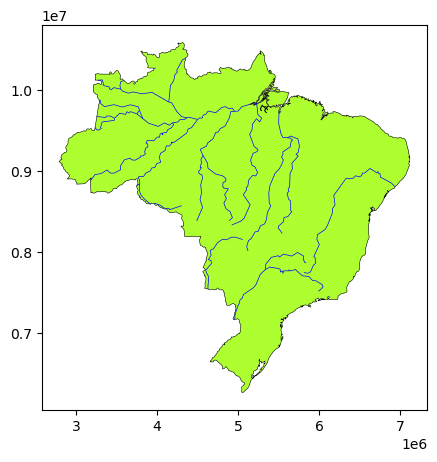

In [66]:
base = brazil5880.plot(facecolor="greenyellow", edgecolor='black', linewidth=0.4,figsize=(5,5))
rivers_brazil5880.plot(edgecolor='blue', linewidth=0.5,
                    ax=base)

We can create our own mask for clipping:

Let me get the **bounding box** of the map (the smallest possible rectangle that completely encloses a geometric shape or set of shapes):

In [67]:
brazil5880.total_bounds #[minx, miny, maxx, maxy]

array([ 2793074.63914733,  6264891.06203913,  7120881.08835731,
       10586462.14322563])

In [69]:
# saving the output
minx, miny, maxx, maxy=brazil5880.total_bounds
minx, miny, maxx, maxy

(np.float64(2793074.6391473296),
 np.float64(6264891.0620391285),
 np.float64(7120881.088357305),
 np.float64(10586462.143225627))

I will combine those coordinates with the _centroid_ (mid_x,mid_y)to create a BOX of the north and south of Brazil:

<Axes: >

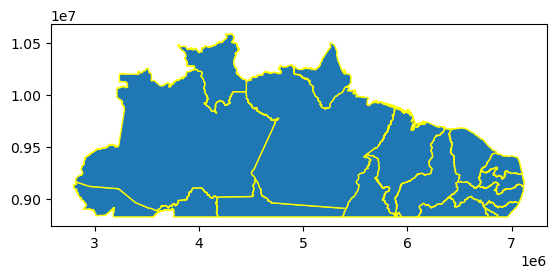

In [70]:
north_mask = [minx, mid_y, maxx, maxy]
south_mask = [minx, minx, maxx, mid_y]

# split Brazil
states_brazil5880.clip(north_mask).plot(edgecolor="yellow")

<Axes: >

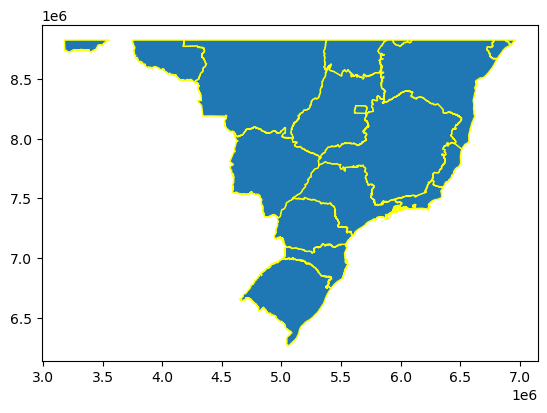

In [71]:
states_brazil5880.clip(south_mask).plot(edgecolor="yellow")

As you see, with clip we can cut polygons (not respecting the borders).

## III. Spatial Joins

We’re familiar with **merging**, which joins tables using common keys. Spatial joins, by contrast, rely solely on **geometry columns** to perform various types of filtering. 

Let me use the brazilian large airports and states:

In [72]:
large_airports.head()

,airport_type,elevation_ft,region,municipality,geometry
airport_name,,,,,
Guarulhos - Governador André Franco Montoro International Airport,large_airport,2461.0,São Paulo,São Paulo,POINT (5769392.959 7387510.487)
Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro,POINT (6102623.812 7436387.271)
Presidente Juscelino Kubitschek International Airport,large_airport,3497.0,Distrito Federal,Brasília,POINT (5651010.181 8235390.09)
Deputado Luiz Eduardo Magalhães International Airport,large_airport,64.0,Bahia,Salvador,POINT (6700330.807 8520415.591)
Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte,POINT (6051718.72 7797008.905)


...and:

In [73]:
states_brazil5880.head()

,state_name,state_code,geometry
0,Acre,BR12,"MULTIPOLYGON (((3374854.317 8740996.704, 33745..."
1,Alagoas,BR27,"MULTIPOLYGON (((7038407.237 8973545.06, 703823..."
2,Amapá,BR16,"MULTIPOLYGON (((5393641.625 10233907.833, 5394..."
3,Amazonas,BR13,"MULTIPOLYGON (((4499820.936 9906611.648, 45003..."
4,Bahia,BR29,"MULTIPOLYGON (((6618113.779 7946308.264, 66178..."


In [78]:
# as before
states_brazil5880.set_index('state_name',inplace=True)

### a. Within

Let's ask:
> The large airports whose geometries are within the borders of a state in Brazil.

In [79]:
airports_within_states = gpd.sjoin(
    large_airports,         # LEFT: airports we want to filter/keep
    states_brazil5880,      # RIGHT: spatial boundaries to check against
    how='inner',            # return geometries that match in both LEFT/RIGHT (jointype)
    predicate='within'      # spatial condition: LEFT geometry within RIGHT geometry
)

# these are:
airports_within_states

,airport_type,elevation_ft,region,municipality,geometry,state_name,state_code
airport_name,,,,,,,
Guarulhos - Governador André Franco Montoro International Airport,large_airport,2461.0,São Paulo,São Paulo,POINT (5769392.959 7387510.487),São Paulo,BR35
Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro,POINT (6102623.812 7436387.271),Rio de Janeiro,BR33
Presidente Juscelino Kubitschek International Airport,large_airport,3497.0,Distrito Federal,Brasília,POINT (5651010.181 8235390.09),Distrito Federal,BR53
Deputado Luiz Eduardo Magalhães International Airport,large_airport,64.0,Bahia,Salvador,POINT (6700330.807 8520415.591),Bahia,BR29
Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte,POINT (6051718.72 7797008.905),Minas Gerais,BR31
Eduardo Gomes International Airport,large_airport,264.0,Amazonas,Manaus,POINT (4327494.283 9662122.706),Amazonas,BR13
Hercílio Luz International Airport,large_airport,16.0,Santa Catarina,Florianópolis,POINT (5537273.577 6926234.097),Santa Catarina,BR42
Val de Cans/Júlio Cezar Ribeiro International Airport,large_airport,54.0,Pará,Belém,POINT (5614728.302 9846773.655),Pará,BR15


We just performed a point-to-polygon spatial join.
Notice that the result preserves the original geometries from the LEFT GeoDataFrame — specifically, only those features whose spatial relationship satisfied both the predicate (e.g., 'within') and the join type ('inner').
The non-geometric attributes (columns) from the RIGHT GeoDataFrame are joined to the matching rows.

### b. Contains

Importantly, if the LEFT GeoDataFrame contains polygons and the RIGHT contains points (a polygon-to-point join), you’ll typically need to use a different predicate — such as 'contains' — to express the spatial relationship correctly.

> Brazilian states that house large airports

In [80]:
states_containing_LargeAirports = gpd.sjoin(states_brazil5880,large_airports,how='inner',
                                            predicate='contains')

states_containing_LargeAirports

,state_code,geometry,airport_name,airport_type,elevation_ft,region,municipality
state_name,,,,,,,
Amazonas,BR13,"MULTIPOLYGON (((4499820.936 9906611.648, 45003...",Eduardo Gomes International Airport,large_airport,264.0,Amazonas,Manaus
Bahia,BR29,"MULTIPOLYGON (((6618113.779 7946308.264, 66178...",Deputado Luiz Eduardo Magalhães International ...,large_airport,64.0,Bahia,Salvador
Distrito Federal,BR53,"MULTIPOLYGON (((5709200.339 8232316.484, 57090...",Presidente Juscelino Kubitschek International ...,large_airport,3497.0,Distrito Federal,Brasília
Minas Gerais,BR31,"MULTIPOLYGON (((5730280.854 8106234.254, 57299...",Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte
Pará,BR15,"MULTIPOLYGON (((5842059.053 9886741.08, 584156...",Val de Cans/Júlio Cezar Ribeiro International ...,large_airport,54.0,Pará,Belém
Rio de Janeiro,BR33,"MULTIPOLYGON (((5957764.631 7386508.56, 595773...",Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro
Santa Catarina,BR42,"MULTIPOLYGON (((5384989.919 6745543.64, 538466...",Hercílio Luz International Airport,large_airport,16.0,Santa Catarina,Florianópolis
São Paulo,BR35,"MULTIPOLYGON (((5619062.728 7205958.887, 56186...",Guarulhos - Governador André Franco Montoro In...,large_airport,2461.0,São Paulo,São Paulo


### c. Intersects

'Contains' is literally strict: Any airport located exactly on a state boundary — whether due to data precision, snapping, or real geography — will be excluded, even if it’s “practically” inside the state. More flexibility is achieved with **intersects**.

> Large airports whose location is anywhere belonging to a particular state

In [81]:
## Intersects needs at least a common point between both GeoDFs. 
gpd.sjoin(states_brazil5880,large_airports,
          how='inner', predicate='intersects')

,state_code,geometry,airport_name,airport_type,elevation_ft,region,municipality
state_name,,,,,,,
Amazonas,BR13,"MULTIPOLYGON (((4499820.936 9906611.648, 45003...",Eduardo Gomes International Airport,large_airport,264.0,Amazonas,Manaus
Bahia,BR29,"MULTIPOLYGON (((6618113.779 7946308.264, 66178...",Deputado Luiz Eduardo Magalhães International ...,large_airport,64.0,Bahia,Salvador
Distrito Federal,BR53,"MULTIPOLYGON (((5709200.339 8232316.484, 57090...",Presidente Juscelino Kubitschek International ...,large_airport,3497.0,Distrito Federal,Brasília
Minas Gerais,BR31,"MULTIPOLYGON (((5730280.854 8106234.254, 57299...",Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte
Pará,BR15,"MULTIPOLYGON (((5842059.053 9886741.08, 584156...",Val de Cans/Júlio Cezar Ribeiro International ...,large_airport,54.0,Pará,Belém
Rio de Janeiro,BR33,"MULTIPOLYGON (((5957764.631 7386508.56, 595773...",Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro
Santa Catarina,BR42,"MULTIPOLYGON (((5384989.919 6745543.64, 538466...",Hercílio Luz International Airport,large_airport,16.0,Santa Catarina,Florianópolis
São Paulo,BR35,"MULTIPOLYGON (((5619062.728 7205958.887, 56186...",Guarulhos - Governador André Franco Montoro In...,large_airport,2461.0,São Paulo,São Paulo


### d. Touches

We also have 'touches', a more stringent predicate than 'intersects'. It returns geometries that:
 - Share a border (for polygons or lines), or
 - Contact at exactly one point (for points or endpoints).

> Which states are neighbors of 'BAHIA", including BAHIA

In [82]:
# Neighbors of Bahia?
gpd.sjoin(N_brazil.loc[N_brazil.state_name=='Bahia',:],N_brazil,how='inner', predicate='intersects').shape

(6, 6)

That is, Bahia seems to share borders with 5 states:

<Axes: >

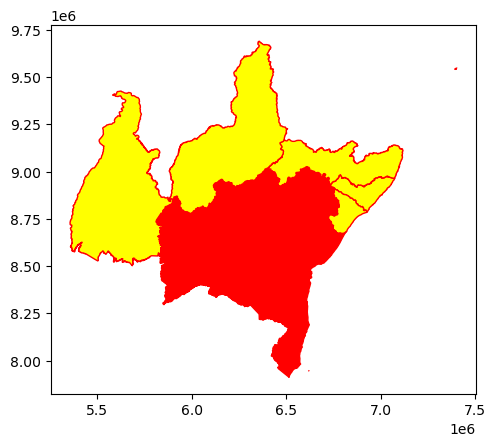

In [83]:
base=gpd.sjoin(N_brazil,N_brazil.loc[N_brazil.state_name=='Bahia',:],
               how='inner', 
               predicate='intersects').plot(color='yellow',edgecolor='red')
N_brazil.loc[N_brazil.state_name=='Bahia',:].plot(ax=base, color='red')

However, because many free GeoDataFrames — especially those sourced as Shapefiles — contain topological imperfections like gaps, overlaps, or misaligned vertices, 'touches' often fails to detect what should be adjacent features. Ironically, this “failure” can be useful: 'touches' acts as a diagnostic tool — highlighting where boundaries are not perfectly aligned.

In [84]:
gpd.sjoin(N_brazil.loc[N_brazil.state_name=='Bahia',:],N_brazil,how='inner', predicate='touches').shape

(4, 6)

See the neighbor that disappears:

<Axes: >

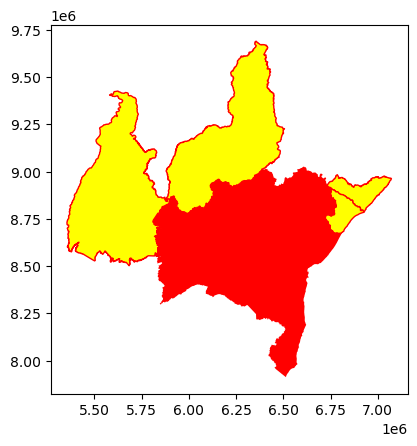

In [85]:
base=gpd.sjoin(N_brazil,N_brazil.loc[N_brazil.state_name=='Bahia',:],
               how='inner', 
               predicate='touches').plot(color='yellow',edgecolor='red')
N_brazil.loc[N_brazil.state_name=='Bahia',:].plot(ax=base, color='red')

### e. Crosses

When we have **lines**, we may need **crosses**. Let me subset our rivers:

In [93]:
amazonSystem=rivers_brazil5880[rivers_brazil5880.SYSTEM=='Amazon']
amazonSystem.set_index('RIVER',inplace=True)

Then,
> Which rivers from the Amazon system are intersecting states?

In [94]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='intersects')

,SYSTEM,geometry,state_name,state_code
RIVER,,,,
Madre de Dios,Amazon,"LINESTRING (3747782.967 8816805.526, 3784022.8...",Rondônia,BR11
Guapore,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378...",Rondônia,BR11
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Mato Grosso,BR51
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Pará,BR15
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Mato Grosso,BR51
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Pará,BR15
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Mato Grosso,BR51
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Pará,BR15
Purus,Amazon,"LINESTRING (3179817.343 8884480.014, 3233812.4...",Acre,BR12


A count of the result:

In [95]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='intersects').shape

(20, 4)

Alternatively,

> Which rivers from the Amazon system are crossing states?

In [96]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='crosses')

,SYSTEM,geometry,state_name,state_code
RIVER,,,,
Madre de Dios,Amazon,"LINESTRING (3747782.967 8816805.526, 3784022.8...",Rondônia,BR11
Guapore,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378...",Rondônia,BR11
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Mato Grosso,BR51
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Pará,BR15
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Mato Grosso,BR51
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Pará,BR15
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Mato Grosso,BR51
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Pará,BR15
Purus,Amazon,"LINESTRING (3179817.343 8884480.014, 3233812.4...",Acre,BR12


You got one less:

In [97]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='crosses').shape

(19, 4)

Again, _intersects_ means both geometries have some 'space' in common. But **crosses** is an intersection that has to cross the spatial object. From the result above, there is one river that shares space with the state, but is not crossing its border:

In [99]:
# Get intersects result
intersects_result = gpd.sjoin(amazonSystem,states_brazil5880, how='inner', predicate='intersects')
intersects_result

,SYSTEM,geometry,state_name,state_code
RIVER,,,,
Madre de Dios,Amazon,"LINESTRING (3747782.967 8816805.526, 3784022.8...",Rondônia,BR11
Guapore,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378...",Rondônia,BR11
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Mato Grosso,BR51
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Pará,BR15
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Mato Grosso,BR51
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Pará,BR15
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Mato Grosso,BR51
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Pará,BR15
Purus,Amazon,"LINESTRING (3179817.343 8884480.014, 3233812.4...",Acre,BR12


In [100]:
# Get crosses result
crosses_result = gpd.sjoin(amazonSystem,states_brazil5880, how='inner', predicate='crosses')
crosses_result

,SYSTEM,geometry,state_name,state_code
RIVER,,,,
Madre de Dios,Amazon,"LINESTRING (3747782.967 8816805.526, 3784022.8...",Rondônia,BR11
Guapore,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378...",Rondônia,BR11
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Mato Grosso,BR51
Rio Juruena,Amazon,"LINESTRING (4488340.769 8382801.957, 4561243.9...",Pará,BR15
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Mato Grosso,BR51
Rio Teles Pires,Amazon,"LINESTRING (4890008.905 8388474.8, 4929569.193...",Pará,BR15
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Mato Grosso,BR51
Xingu,Amazon,"MULTILINESTRING ((4921614.129 8334835.678, 503...",Pará,BR15
Purus,Amazon,"LINESTRING (3179817.343 8884480.014, 3233812.4...",Acre,BR12


In [128]:
river_notCrossing=list(set(intersects_result.index)-set(crosses_result.index))
river_notCrossing

['Tapajos']

In [156]:
# Find indexes/columns
state_notCrossed=intersects_result.loc[river_notCrossing,'state_name'].to_list()
state_notCrossed

['Pará']

Now we know the river that is not crossing an state, and the name of that state.

<Axes: >

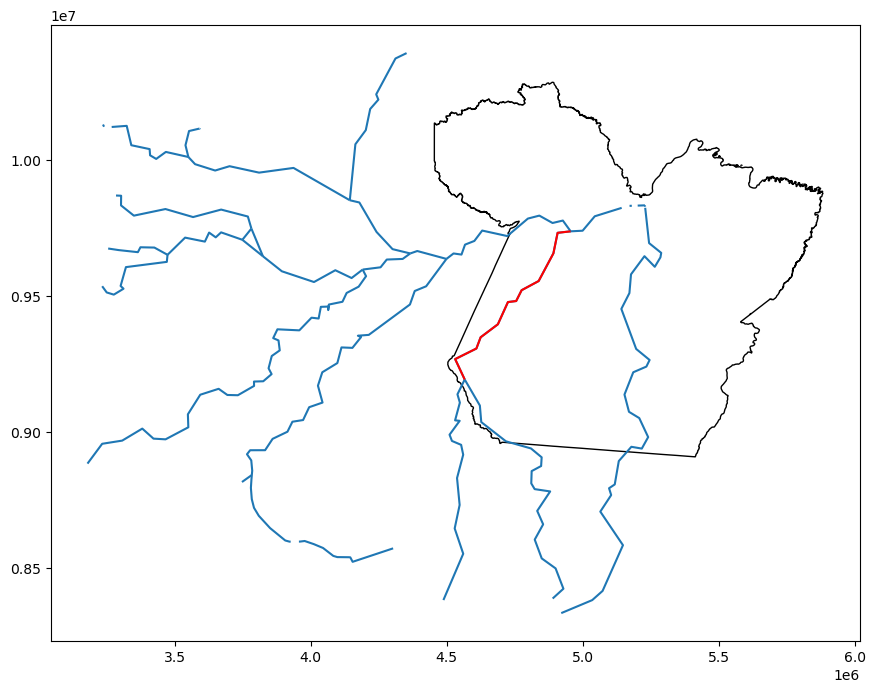

In [157]:
base=states_brazil5880.loc[state_notCrossed,:].plot(color='w',edgecolor='k',figsize=(12, 8))
amazonSystem.plot(ax=base)
amazonSystem.loc[river_notCrossing,:].plot(color='red',ax=base)


## IV. Spatial Overlay

As the name implies, you need two inputs. We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will see the use of _intersection_, _union_, _difference_, and _symmetric difference_.
Let's remember these results:

In [158]:
N_brazil

,state_name,state_code,geometry
0,Acre,BR12,"MULTIPOLYGON (((3374854.317 8740996.704, 33745..."
1,Alagoas,BR27,"MULTIPOLYGON (((7038407.237 8973545.06, 703823..."
2,Amapá,BR16,"MULTIPOLYGON (((5393641.625 10233907.833, 5394..."
3,Amazonas,BR13,"MULTIPOLYGON (((4499820.936 9906611.648, 45003..."
4,Bahia,BR29,"MULTIPOLYGON (((6618113.779 7946308.264, 66178..."
5,Ceará,BR23,"MULTIPOLYGON (((6566662.514 9672539.24, 656620..."
9,Maranhão,BR21,"MULTIPOLYGON (((5766252.527 8999101.029, 57658..."
10,Mato Grosso,BR51,"MULTIPOLYGON (((4718274.258 8081710.261, 47189..."
13,Pará,BR15,"MULTIPOLYGON (((5842059.053 9886741.08, 584156..."
14,Paraíba,BR25,"MULTIPOLYGON (((7114219.231 9185077.165, 71147..."


In [159]:
S_brazil

,state_name,state_code,geometry
0,Acre,BR12,"MULTIPOLYGON (((3374854.317 8740996.704, 33745..."
1,Alagoas,BR27,"MULTIPOLYGON (((7038407.237 8973545.06, 703823..."
4,Bahia,BR29,"MULTIPOLYGON (((6618113.779 7946308.264, 66178..."
6,Distrito Federal,BR53,"MULTIPOLYGON (((5709200.339 8232316.484, 57090..."
7,Espírito Santo,BR32,"MULTIPOLYGON (((7566463.228 7535792.386, 75661..."
8,Goiás,BR52,"MULTIPOLYGON (((5714835.191 8093308.232, 57153..."
10,Mato Grosso,BR51,"MULTIPOLYGON (((4718274.258 8081710.261, 47189..."
11,Mato Grosso do Sul,BR50,"MULTIPOLYGON (((4643554.93 7541102.839, 464377..."
12,Minas Gerais,BR31,"MULTIPOLYGON (((5730280.854 8106234.254, 57299..."
15,Paraná,BR41,"MULTIPOLYGON (((5445488.893 7090357.876, 54459..."


Let me plot both of them:

<Axes: >

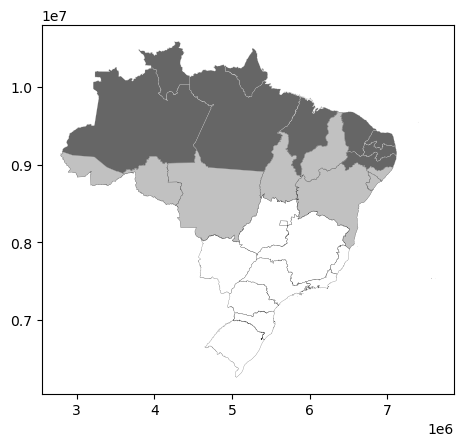

In [160]:
base= N_brazil.plot(facecolor='black', edgecolor='white',linewidth=0.2, alpha=0.6)
S_brazil.plot(facecolor='white', edgecolor='black',linewidth=0.2,ax=base, alpha=0.6)

The grey area reminds you that the coordinates we used to split the states did not give us a clean cut. Here you see the states in common:

In [ ]:
set(S_brazil.state_name) & set(N_brazil.state_name)

The same happened in East vs West:

In [ ]:
set(E_brazil.state_name) & set(W_brazil.state_name)

In [ ]:
# visualizing
base= E_brazil.plot(facecolor='black', edgecolor='white',linewidth=0.2, alpha=0.6)
W_brazil.plot(facecolor='white', edgecolor='black',linewidth=0.2,ax=base, alpha=0.6)

Let's play with these GDFs, keep in mind the position of the GDFs:

```
GDF_left.overlay(GDF_right, ...)
```

### a. Intersection

We keep what is common between _left_ and _right_ GDFs :

In [ ]:
NS_brazil=N_brazil.overlay(S_brazil, how="intersection",keep_geom_type=True)
# see results
NS_brazil

Notice we got more rows than when we did this operation:

```
set(S_brazil.state_name) & set(N_brazil.state_name)
```
We have three more polygons:

In [ ]:
NS_brazil[NS_brazil.state_name_1!= NS_brazil.state_name_2]

In fact, we are NOT intersecting state names, we are intersecting geometries. Then, the input maps have some topological issues.

This is the amount of area that is in fact a topological problem:

In [ ]:
NS_brazil[NS_brazil.state_name_1!= NS_brazil.state_name_2].geometry.area.sum()

A way to measure the share of the low quality:

In [ ]:
NS_brazil[NS_brazil.state_name_1!= NS_brazil.state_name_2].geometry.area.sum()/  \
NS_brazil[NS_brazil.state_name_1== NS_brazil.state_name_2].geometry.area.sum() #continues from above

So, spatial overlay operations do their best to give you true results; but unfortunately, as the quality of the sources is not perfect, you may get messy results. It is our job to detect and make decisions. Let's keep two GDFs, one with the unperfect result, and another with a 'valid' output.

In [ ]:
NS_brazil_messy=NS_brazil.copy()
NS_brazil=NS_brazil[NS_brazil.state_name_1== NS_brazil.state_name_2]

This should be what we expected to see:

In [ ]:
NS_brazil

The clean data has minor things to improve, delete redundant columns, rename columns, and reset the index so they are a correlative sequence. 

In [ ]:
# avoid redundancy
keep=['state_name_1','state_code_1','geometry']
NS_brazil=NS_brazil.loc[:,keep]
NS_brazil.rename(columns={'state_name_1':'state_name','state_code_1':'state_code'},inplace=True)

# reset for correlative sequence
NS_brazil.reset_index(drop=True, inplace=True)

Based on the previous case, we may expect a similar situation here:

In [ ]:
# keeping the overlay
WE_brazil=W_brazil.overlay(E_brazil, how="intersection",keep_geom_type=True)
WE_brazil[WE_brazil.state_name_1!= WE_brazil.state_name_2]

Let's do the same as before:

In [ ]:
WE_brazil_messy=WE_brazil.copy()
WE_brazil=WE_brazil[WE_brazil.state_name_1== WE_brazil.state_name_2]

keep=['state_name_1','state_code_1','geometry']
WE_brazil=WE_brazil.loc[:,keep]
WE_brazil.rename(columns={'state_name_1':'state_name','state_code_1':'state_code'},inplace=True)
WE_brazil.reset_index(drop=True, inplace=True)

### b. Union

Different from UNION_ALL (which acts as DISSOLVE), here we will combine the left and right GDFs. 

In [ ]:
NS_brazil.info()

In [ ]:
WE_brazil.info()

In [ ]:
# now
NS_brazil.overlay(WE_brazil,how="union",keep_geom_type=True)

As you see, geometries are fine, but missing values were created where no intersection exists. Notice this operation  identifies the intersection. 

Pandas has a _concat()_ function, which just pastes two tables, one of top of the other. Notice this will give you one more row (Mato Grosso appears twice) as nothing is done spite of geometries intersect.

In [ ]:
# appending
import pandas as pd

pd.concat([NS_brazil,WE_brazil],ignore_index=True)

Let me create an object to save the overlay result:

In [ ]:
MidBrazil=NS_brazil.overlay(WE_brazil,how="union",keep_geom_type=True).dissolve()
MidBrazil

In [ ]:
# some cleaning

MidBrazil['country']='Brazil'
MidBrazil['region']='center'
# reordering
MidBrazil=MidBrazil.loc[:,['country','region','geometry']]

MidBrazil

In [ ]:
# see it
base=brazil5880.plot(facecolor='yellow')
MidBrazil.plot(ax=base)

### c. Difference

Here, you keep what belongs to the left GDF that is not in the right GDF:

In [ ]:
# we keep nothern states that are not in the southern ones
N_brazil.overlay(S_brazil, how='difference')

In [ ]:
# using set operations:
set(N_brazil.state_name)- set(S_brazil.state_name)

We got a clean result (remember we are using the not messy GDFs). Let's plot this:

In [ ]:
base=N_brazil.plot(color='yellow', edgecolor='black',alpha=0.1)
N_brazil.overlay(S_brazil, how='difference').plot(ax=base)

Keep in mind that **difference** is not commutative:

In [ ]:
S_brazil.overlay(N_brazil, how='difference')

This a totally different result:

In [ ]:
base=N_brazil.plot(color='yellow', edgecolor='black',alpha=0.1)
S_brazil.overlay(N_brazil, how='difference').plot(ax=base)

### d. Symmetric Difference

Here, we keep what is not in the intersection but in both GDFs. Notice that this operation is commutative!

In [ ]:
N_brazil.overlay(S_brazil, how='symmetric_difference')

This operation gave a clean result again. Let's plot it:

In [ ]:
N_brazil.overlay(S_brazil, how='symmetric_difference').plot()


_____________


# Validity of Geometries

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
S_brazil[~S_brazil.is_valid]

In [ ]:
# see the invalid:
S_brazil[~S_brazil.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(S_brazil[~S_brazil.is_valid].geometry)

This is the report:

In [ ]:
explain_validity(S_brazil.geometry).str.split("[",expand=True)[0].value_counts()

Let's use **make_valid**:

In [ ]:
S_brazil_valid=S_brazil.copy()

S_brazil_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in S_brazil['geometry'] ]

#any invalid?
S_brazil_valid[~S_brazil_valid.is_valid]

The use of *make_valid* may output **collections**, this is not desirable:

In [ ]:
pd.Series([type(x) for x in S_brazil_valid.geometry]).value_counts()

## Buffers and Validity

The buffering process helps cleaning simple invalidities:

In [ ]:
S_brazil_valid=S_brazil.copy()

S_brazil_valid['geometry'] = S_brazil_valid['geometry'].buffer(0)

#any invalid?
S_brazil_valid[~S_brazil_valid.is_valid]

This 'buffer trick' may not always work:

In [ ]:
# previously
indicatorsByRegion.plot(column =indicatorsByRegion.index,
                        edgecolor='white',
                        figsize=(15, 10))

The worst cases seem AFRICA and EAST AND SOUTHEAST ASIA, as both show some lines that should have disappeared after the dissolving we did a while ago.

Did the dissolving process created invalid geometries?

In [ ]:
indicatorsByRegion.geometry.is_valid.value_counts()

Since we do not have invalid geometries, we know the dissolving created some gaps, so the goal is to snap the boundaries together to eliminate these microscopic gaps.

We could try the trick  of buffer(0), again:

In [ ]:
indicatorsByRegion_prjd=indicatorsByRegion.to_crs("ESRI:54052").copy()
indicatorsByRegion_prjd['geometry'] = indicatorsByRegion_prjd.buffer(0)

# previously
indicatorsByRegion_prjd.plot(column =indicatorsByRegion_prjd.index,
                        edgecolor='white',
                        figsize=(15, 10))

It did not work either. We may increase the buffer:

In [ ]:
indicatorsByRegion_prjd['geometry'] = indicatorsByRegion_prjd.buffer(1)

indicatorsByRegion_prjd.plot(column =indicatorsByRegion_prjd.index,
                        edgecolor='white',
                        figsize=(15, 10))

The last version did got rid of the gaps, at least visually. Let's just check the counts in each case:

In [ ]:
[(r,len(g.geoms)) for r,g in zip(indicatorsByRegion.index,indicatorsByRegion.geometry) if g.geom_type.startswith('Multi')]

In [ ]:
[(r,len(g.geoms)) for r,g in zip(indicatorsByRegion_prjd.index,indicatorsByRegion_prjd.geometry)  if g.geom_type.startswith('Multi')]

It seems AFRICA issue was solved, but not EAST AND SOUTHEAST ASIA. Thee seems to be a really big issue in those borders (Mongolia and China). Let's explore:

In [ ]:
china=indicators[indicators.Country.isin(['CHINA'])]
mongolia=indicators[indicators.Country.isin(['MONGOLIA'])]

china.overlay(mongolia, how='intersection',keep_geom_type=False).geometry

So, we have some really bad situation:

- There is an intersection between two countries, and there should be none.
- There intersection includes objects other than polygons: 'GEOMETRYCOLLECTION'

See:


In [ ]:
# Quick count of objects in the GeometryCollection
result_geom = china.overlay(mongolia, how='intersection',keep_geom_type=False).geometry.iloc[0]
if result_geom.geom_type == 'GeometryCollection':
    print(f"Objects in collection: {len(result_geom.geoms)}")
    from collections import Counter
    print(dict(Counter(g.geom_type for g in result_geom.geoms)))

In [ ]:
## see the intersection:
base=china.plot(color='lightgrey')
mongolia.plot(color='yellow',ax=base)
china.overlay(mongolia, how='intersection',keep_geom_type=False).plot(ax=base)

The solution to this, believe me, will not be trivial: the border is not continuous, and creating a 'new frontier' between China and Mongolia will demand more functions than the ones we have taught so far. Situations like this require smart decisions, like get a new map  with a [better quality](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/).